In [1]:
import tensorflow as tf
import time
import numpy as np

from matplotlib import pyplot as plt

%matplotlib inline

def rmse(predictions, actual):
    sse = np.sum(np.square(predictions - actual))
    return np.sqrt(sse / float(actual.shape[0]))

In [19]:
n = 5
hidden = n * 7

# Generate training data and outputs
train_x = np.random.normal(size=(200000, n))

mults = np.arange(n) + 1
bias = -3

train_y = np.dot(train_x, mults) + bias
train_y = np.expand_dims(train_y.astype(np.float32), 1)

# add some noise to X
# train_x = (9 * train_x + np.random.normal(size=train_x.shape)) / 10
train_x = train_x.astype(np.float32)

# Training parameters:
batch_size = 75
epochs = 40

keep_percentage = .5
learn_rate = 1e-4
lambda_ = 0

num_labels = train_y.shape[1]

graph = tf.Graph()
with graph.as_default():
    # Input data. For the training data, we use a placeholder that will be fed
    # at run time with a training minibatch.
    tf_train_dataset = tf.placeholder(tf.float32, shape=(None, n), name='X')
    tf_train_labels = tf.placeholder(
        tf.float32, shape=(None, num_labels), name='y')
    tf_keep_prob = tf.placeholder(tf.float32, name='keep_rate')

    # Variables.
    # w0 = tf.Variable(tf.truncated_normal([n, hidden]), name='w0')
    w0 = tf.get_variable("w0", shape=[n, hidden], 
                         initializer=tf.contrib.layers.xavier_initializer())
    b0 = tf.Variable(tf.zeros([hidden]), name='b0')
    # w1 = tf.Variable(tf.truncated_normal([hidden, num_labels]), name='w1')
    w1 = tf.get_variable("w1", shape=[hidden, num_labels], 
                         initializer=tf.contrib.layers.xavier_initializer())
    b1 = tf.Variable(tf.zeros([num_labels]), name='b1')

    # Training computation.
    logits = tf.nn.relu(tf.matmul(tf_train_dataset, w0) + b0)
    logits = tf.nn.dropout(logits, tf_keep_prob)
    logits = tf.matmul(logits, w1) + b1
    loss = (tf.reduce_sum(tf.square(logits - tf_train_labels)) +
            lambda_ * (tf.nn.l2_loss(w0) + tf.nn.l2_loss(w1)))

    # Optimizer.
    optimizer = tf.train.AdamOptimizer(learn_rate).minimize(loss)

    # Predictions
    train_prediction = logits

Running 106667 batches (40 epochs)
Initialized
Minibatch loss at step 0: 4686.233887
Minibatch RMSE: 7.90463
Train set RMSE: 8.09281
Minibatch loss at step 2667: 1294.767090
Minibatch RMSE: 4.15494
Train set RMSE: 3.88924
Minibatch loss at step 5334: 291.934509
Minibatch RMSE: 1.97293
Train set RMSE: 0.99860
Minibatch loss at step 8001: 288.561096
Minibatch RMSE: 1.96150
Train set RMSE: 0.72456
Minibatch loss at step 10668: 302.234863
Minibatch RMSE: 2.00744
Train set RMSE: 0.59763
Minibatch loss at step 13335: 291.658234
Minibatch RMSE: 1.97200
Train set RMSE: 0.46803
Minibatch loss at step 16002: 239.817383
Minibatch RMSE: 1.78817
Train set RMSE: 0.45399
Minibatch loss at step 18669: 314.759369
Minibatch RMSE: 2.04861
Train set RMSE: 0.40423
Minibatch loss at step 21336: 279.103363
Minibatch RMSE: 1.92909
Train set RMSE: 0.37961
Minibatch loss at step 24003: 262.615173
Minibatch RMSE: 1.87124
Train set RMSE: 0.42816
Minibatch loss at step 26670: 133.084610
Minibatch RMSE: 1.33209
Tra

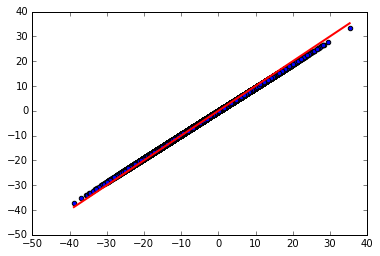

In [20]:
start = time.time()
num_steps = int(np.ceil(epochs * float(train_y.shape[0]) / batch_size))
print("Running %d batches (%d epochs)" % (num_steps, epochs))

with tf.Session(graph=graph) as session:
    tf.initialize_all_variables().run()
    print("Initialized")
    for step in range(num_steps):
        # Pick an offset within the training data, which has been randomized.
        # Note: we could use better randomization across epochs.
        offset = (step * batch_size) % (train_y.shape[0] - batch_size)
        # Generate a minibatch.
        batch_data = train_x[offset:(offset + batch_size), :]
        batch_labels = train_y[offset:(offset + batch_size), :]
        # Prepare a dictionary telling the session where to feed the minibatch.
        # The key of the dictionary is the placeholder node of the graph to be fed,
        # and the value is the numpy array to feed to it.
        feed_dict = {
            tf_train_dataset: batch_data,
            tf_train_labels: batch_labels,
            tf_keep_prob: keep_percentage}
        _, l, predictions = session.run(
            [optimizer, loss, train_prediction], feed_dict=feed_dict)
        if (step % int(np.ceil(float(train_y.shape[0]) / batch_size)) == 0):
            print("Minibatch loss at step %d: %f" % (step, l))
            print("Minibatch RMSE: %.5f" % rmse(predictions, batch_labels))

            print("Train set RMSE: %.5f" % rmse(logits.eval(
                feed_dict={tf_train_dataset: train_x, tf_keep_prob: 1.0}), train_y))
    print("")
    feed_dict = {
        tf_train_dataset: train_x,
        tf_keep_prob: 1.0}
    preds = logits.eval(feed_dict=feed_dict)
    # print preds

print("actual y values:")
print(train_y)
print("\n predictions:")
print(preds)

print("\n Total time: %.3f minutes") % ((time.time() - start) / 60.)

plt.scatter(train_y.reshape([-1, 1]), preds.reshape([-1, 1]))
plt.plot([train_y.min(), train_y.max()], [
         train_y.min(), train_y.max()], 'k-', lw=2, color='r')
plt.show()